# NOTEBOOK FOR THE ANALYSIS OF SINGLE-CELL RNA-SEQUENCING DATA FROM LFSMBP

In [49]:
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import scrublet as scr
import pandas as pd
from matplotlib import rcParams

In [50]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [51]:
results_file = '/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/scanpy/LFSMBP-PDX_scanpy.h5ad'  # the file that will store the analysis results

## READ IN THE DATA FOR LFSMBP-PDX AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [52]:
adata_lfsmbp = sc.read_10x_mtx(
    '/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/data/10XRNA5P/LFSMBP/LFSMBP-PDX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata_lfsmbp.var_names_make_unique()
adata_lfsmbp

# make some metadata
adata_lfsmbp.obs['sample'] = "LFSMBP"
adata_lfsmbp.obs['technology'] = "PDX"
adata_lfsmbp.obs['patient'] = "LFSMB"

... reading from cache file cache/icgc-dkfzlsdf-analysis-B260-projects-chromothripsis_medulloblastoma-data-10XRNA5P-STP-STP-PDX-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [53]:
adata_lfsmbp

AnnData object with n_obs × n_vars = 4724 × 32738
    obs: 'sample', 'technology', 'patient'
    var: 'gene_ids', 'feature_types'

In [54]:
lfsmbp_mouse_cells = pd.read_csv("/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/data/10XRNA5P/LFSMBP/mm10_and_hg19/sample3.mapping.counts.txt", sep = '\t')
lfsmbp_mouse_cells

,cell,count.hg19,count.mm10,total.count,ratio
0,AAACCTGCACGTTGGC-1,750,9,759,83.333333
1,AAACCTGCATCATCCC-1,1742,5,1747,348.400000
2,AAACCTGGTGCACTTA-1,2126,3,2129,708.666667
3,AAACCTGTCAATACCG-1,2367,4,2371,591.750000
4,AAACCTGTCGCGTAGC-1,2518,3,2521,839.333333
...,...,...,...,...,...
4781,TTTGTCATCACCATAG-1,1433,2,1435,716.500000
4782,TTTGTCATCACCCGAG-1,2236,4,2240,559.000000
4783,TTTGTCATCAGAGACG-1,2098,4,2102,524.500000
4784,TTTGTCATCCTGTAGA-1,2377,7,2384,339.571429


In [55]:
lfsmbp_mouse_cells = lfsmbp_mouse_cells[lfsmbp_mouse_cells['ratio'] > 1]
lfsmbp_mouse_cells

,cell,count.hg19,count.mm10,total.count,ratio
0,AAACCTGCACGTTGGC-1,750,9,759,83.333333
1,AAACCTGCATCATCCC-1,1742,5,1747,348.400000
2,AAACCTGGTGCACTTA-1,2126,3,2129,708.666667
3,AAACCTGTCAATACCG-1,2367,4,2371,591.750000
4,AAACCTGTCGCGTAGC-1,2518,3,2521,839.333333
...,...,...,...,...,...
4781,TTTGTCATCACCATAG-1,1433,2,1435,716.500000
4782,TTTGTCATCACCCGAG-1,2236,4,2240,559.000000
4783,TTTGTCATCAGAGACG-1,2098,4,2102,524.500000
4784,TTTGTCATCCTGTAGA-1,2377,7,2384,339.571429


In [56]:
lfsmbp_mouse_cells_barcodes = lfsmbp_mouse_cells['cell']
lfsmbp_mouse_cells_barcodes 

0       AAACCTGCACGTTGGC-1
1       AAACCTGCATCATCCC-1
2       AAACCTGGTGCACTTA-1
3       AAACCTGTCAATACCG-1
4       AAACCTGTCGCGTAGC-1
               ...        
4781    TTTGTCATCACCATAG-1
4782    TTTGTCATCACCCGAG-1
4783    TTTGTCATCAGAGACG-1
4784    TTTGTCATCCTGTAGA-1
4785    TTTGTCATCTTAGCCC-1
Name: cell, Length: 4408, dtype: object

In [57]:
adata = adata_lfsmbp[adata_lfsmbp.obs_names.isin(lfsmbp_mouse_cells_barcodes),:]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [58]:
adata.obs

,sample,technology,patient
AAACCTGCACGTTGGC-1,STP,PDX,ST
AAACCTGCATCATCCC-1,STP,PDX,ST
AAACCTGGTGCACTTA-1,STP,PDX,ST
AAACCTGTCAATACCG-1,STP,PDX,ST
AAACCTGTCGCGTAGC-1,STP,PDX,ST
...,...,...,...
TTTGTCATCACCATAG-1,STP,PDX,ST
TTTGTCATCACCCGAG-1,STP,PDX,ST
TTTGTCATCAGAGACG-1,STP,PDX,ST
TTTGTCATCCTGTAGA-1,STP,PDX,ST


In [59]:
scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.06)

In [60]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 76.9%
Elapsed time: 4.1 seconds


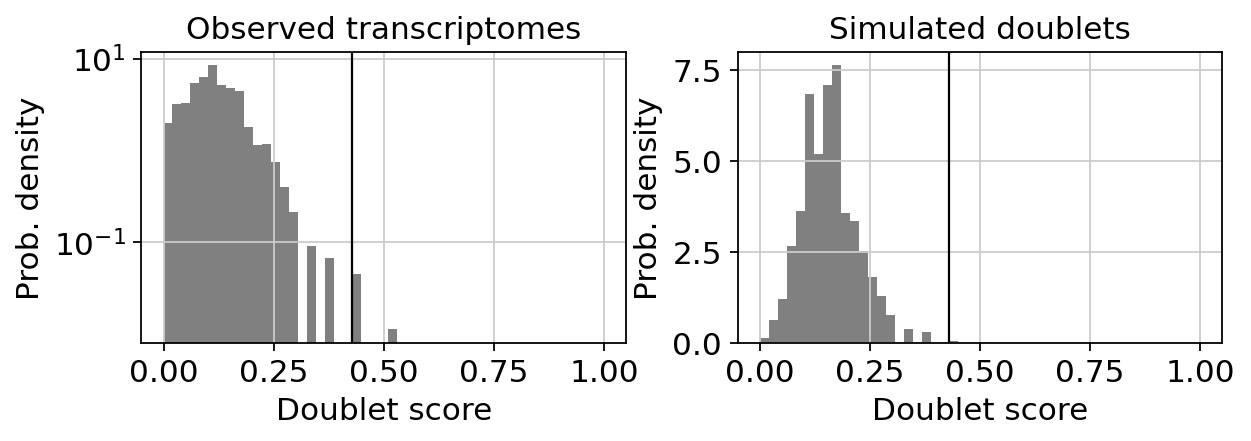

In [61]:
scrub.plot_histogram();

## START PERFORMING THE INITIAL QUALITY CONTROL

normalizing counts per cell
    finished (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


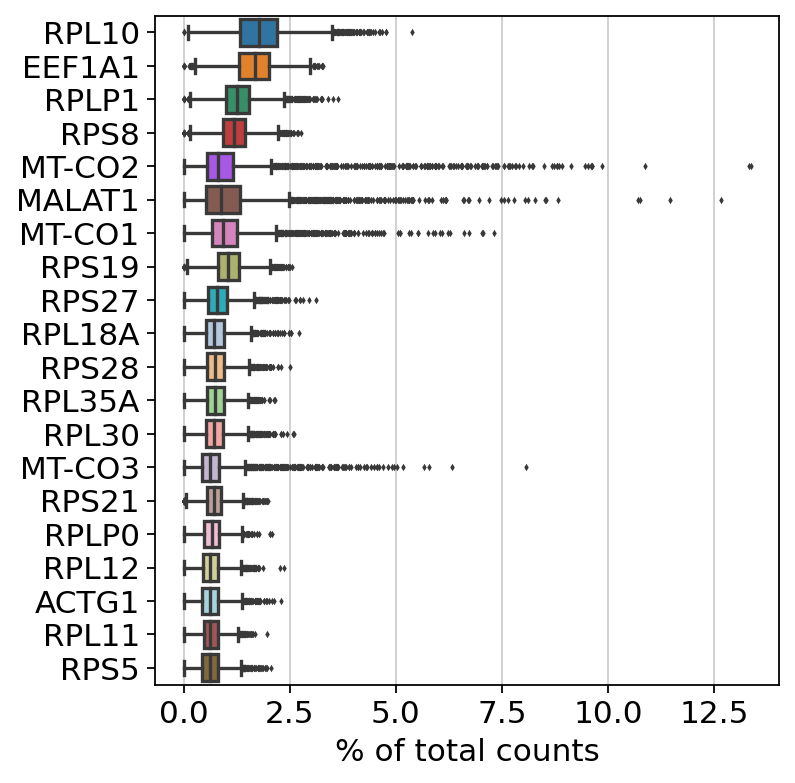

In [62]:
# preprocessing
sc.pl.highest_expr_genes(adata, n_top=20,)

In [63]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 16604 genes that are detected in less than 3 cells


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [64]:
# calculate some quality metrics as for instance mitochondrial percentage
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# and for ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'patient' as categorical
... storing 'feature_types' as categorical


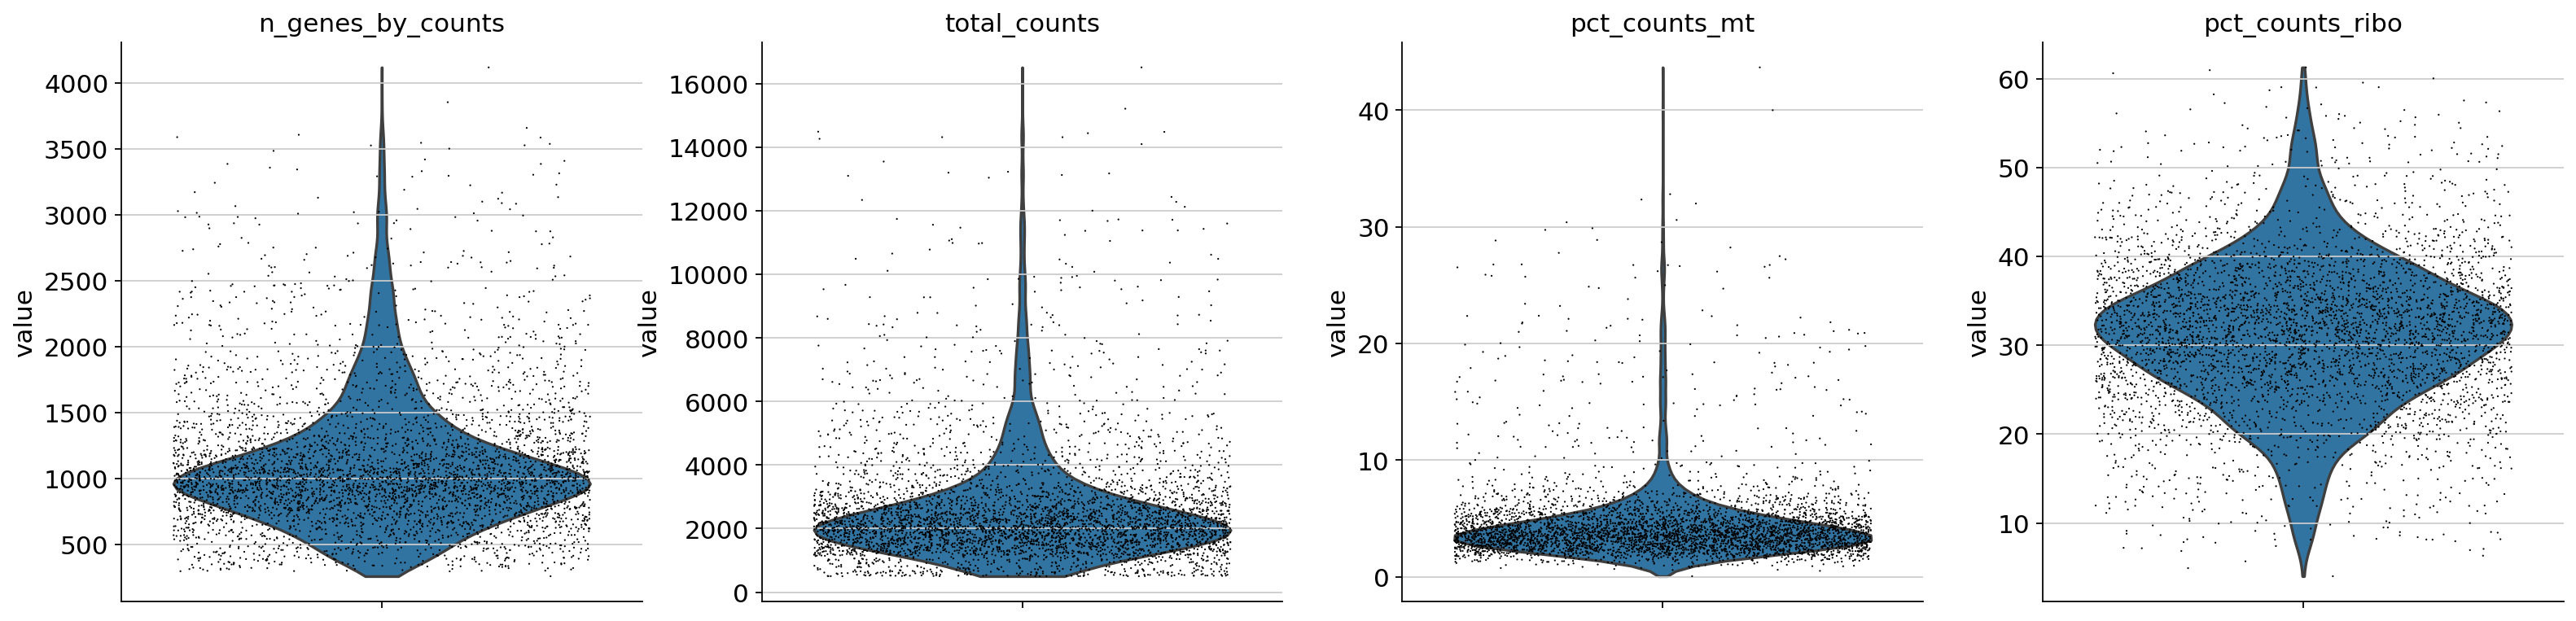

In [65]:
# visualize some QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

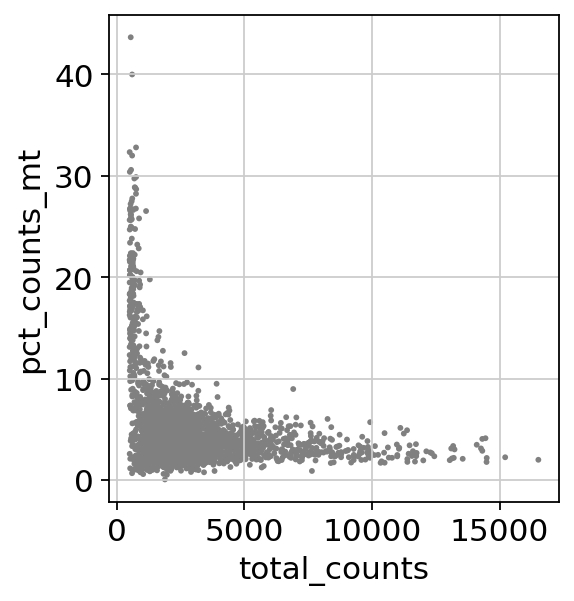

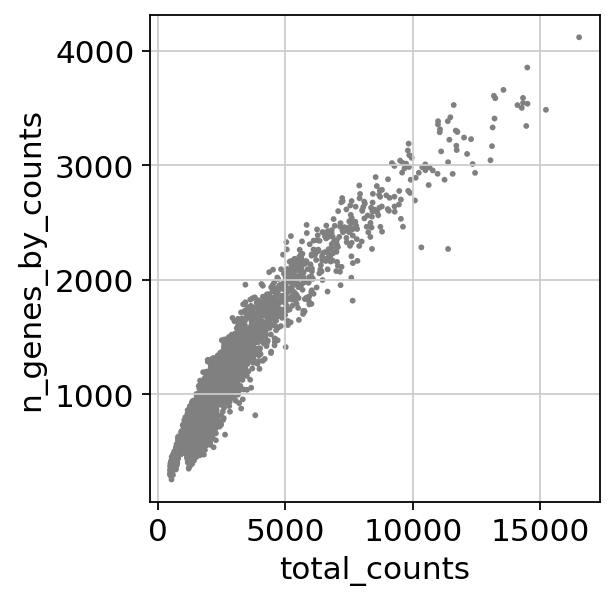

In [66]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [67]:
# do the actual filtering by slicing the object
adata = adata[200 < adata.obs.n_genes_by_counts, :]
adata = adata[500 < adata.obs.total_counts, :]
adata = adata[adata.obs.total_counts < 25000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata = adata[adata.obs.pct_counts_ribo < 40, :]

/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [68]:
adata

View of AnnData object with n_obs × n_vars = 3629 × 16134
    obs: 'sample', 'technology', 'patient', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'

In [69]:
# calculate mean number of genes detected
mean_genes = adata.obs['n_genes'].mean()
print(mean_genes)

# calculate mean number of transcripts detected
mean_counts = adata.obs['total_counts'].mean()
print(mean_counts)

1189.37889225682
2757.7080078125


## PERFORM NORMALIZATION, PCA AND CLUSTERING

In [70]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [71]:
sc.pp.log1p(adata)

In [72]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


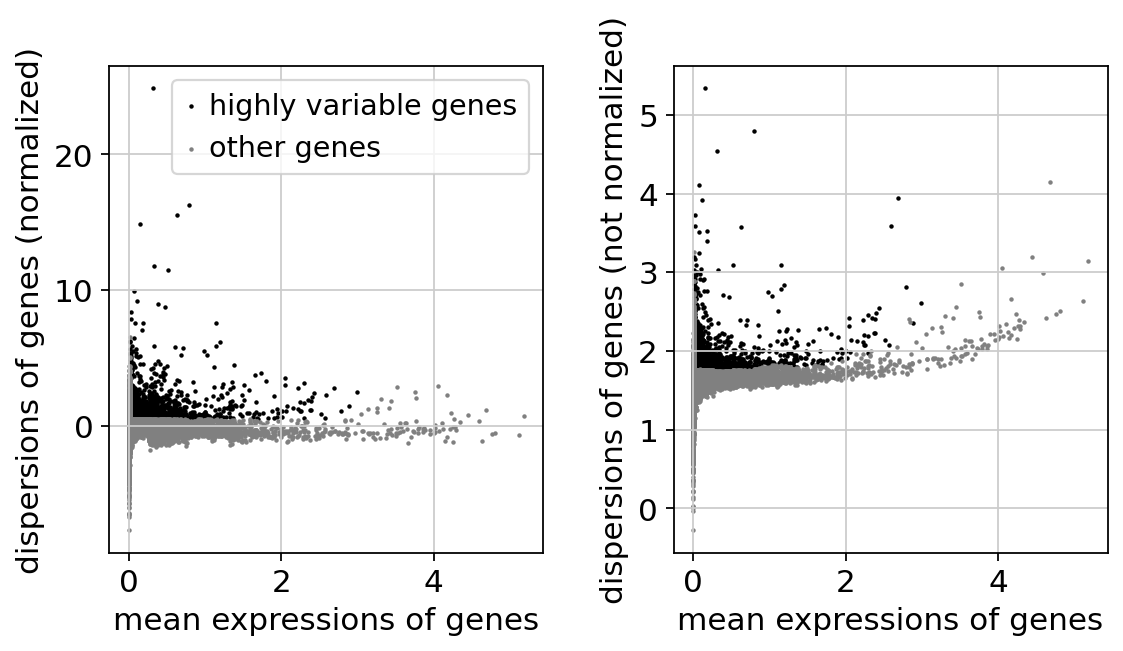

In [73]:
sc.pl.highly_variable_genes(adata)

In [74]:
# set the raw attribute of anndata
adata.raw = adata

In [75]:
adata = adata[:, adata.var.highly_variable]

In [76]:
# regress out effects of total counts per cell and the percentage of mitochondrial genes
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

regressing out ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)


In [77]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


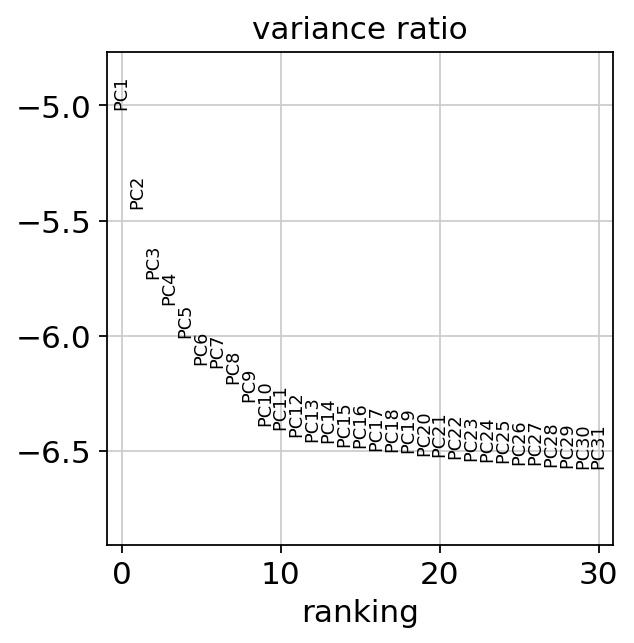

In [78]:
sc.pl.pca_variance_ratio(adata, log=True)

In [79]:
# compute nearest neighbors, UMAP and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=8)
sc.tl.umap(adata, n_components=2, min_dist=0.1,  # Scanpy default = 0.05
           spread=1.0, copy=False, random_state=0)
sc.tl.louvain(adata, resolution= 0.3)
sc.tl.leiden(adata, resolution= 0.3)

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


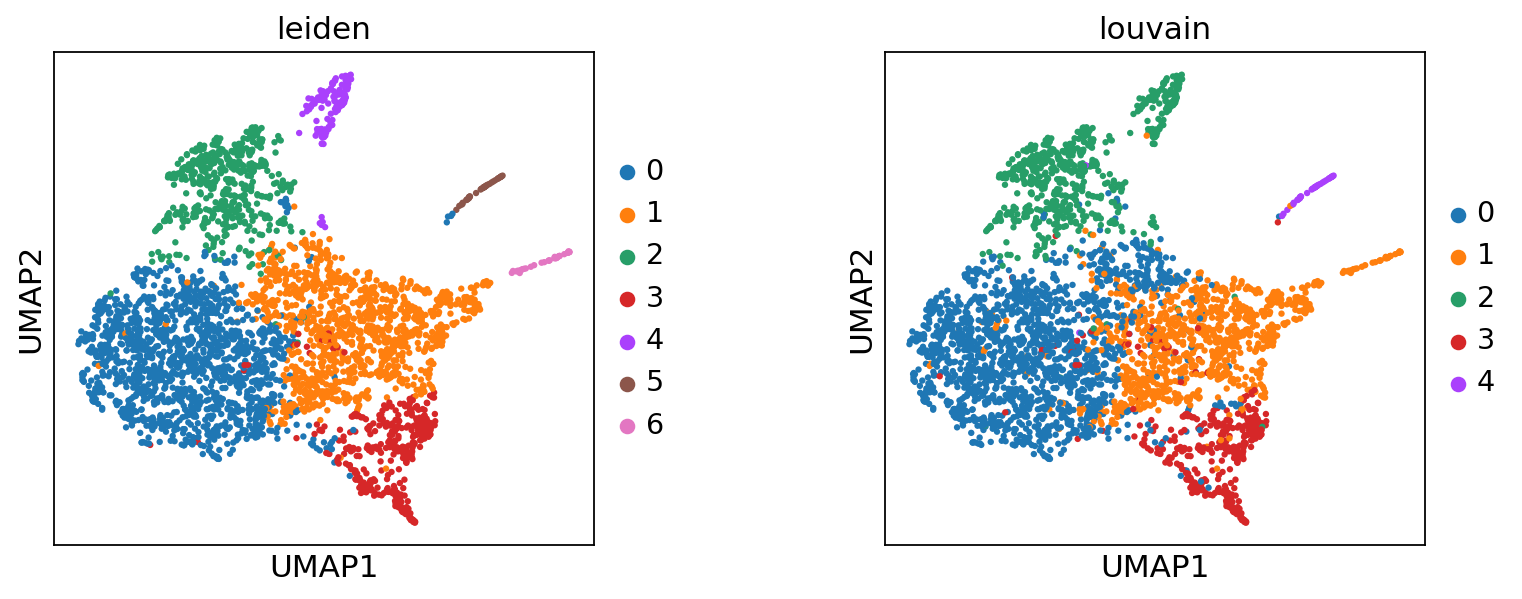

In [80]:
sc.pl.umap(adata, color=['leiden', 'louvain'], save = '_STP-PDX.pdf', wspace = 0.4)

ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


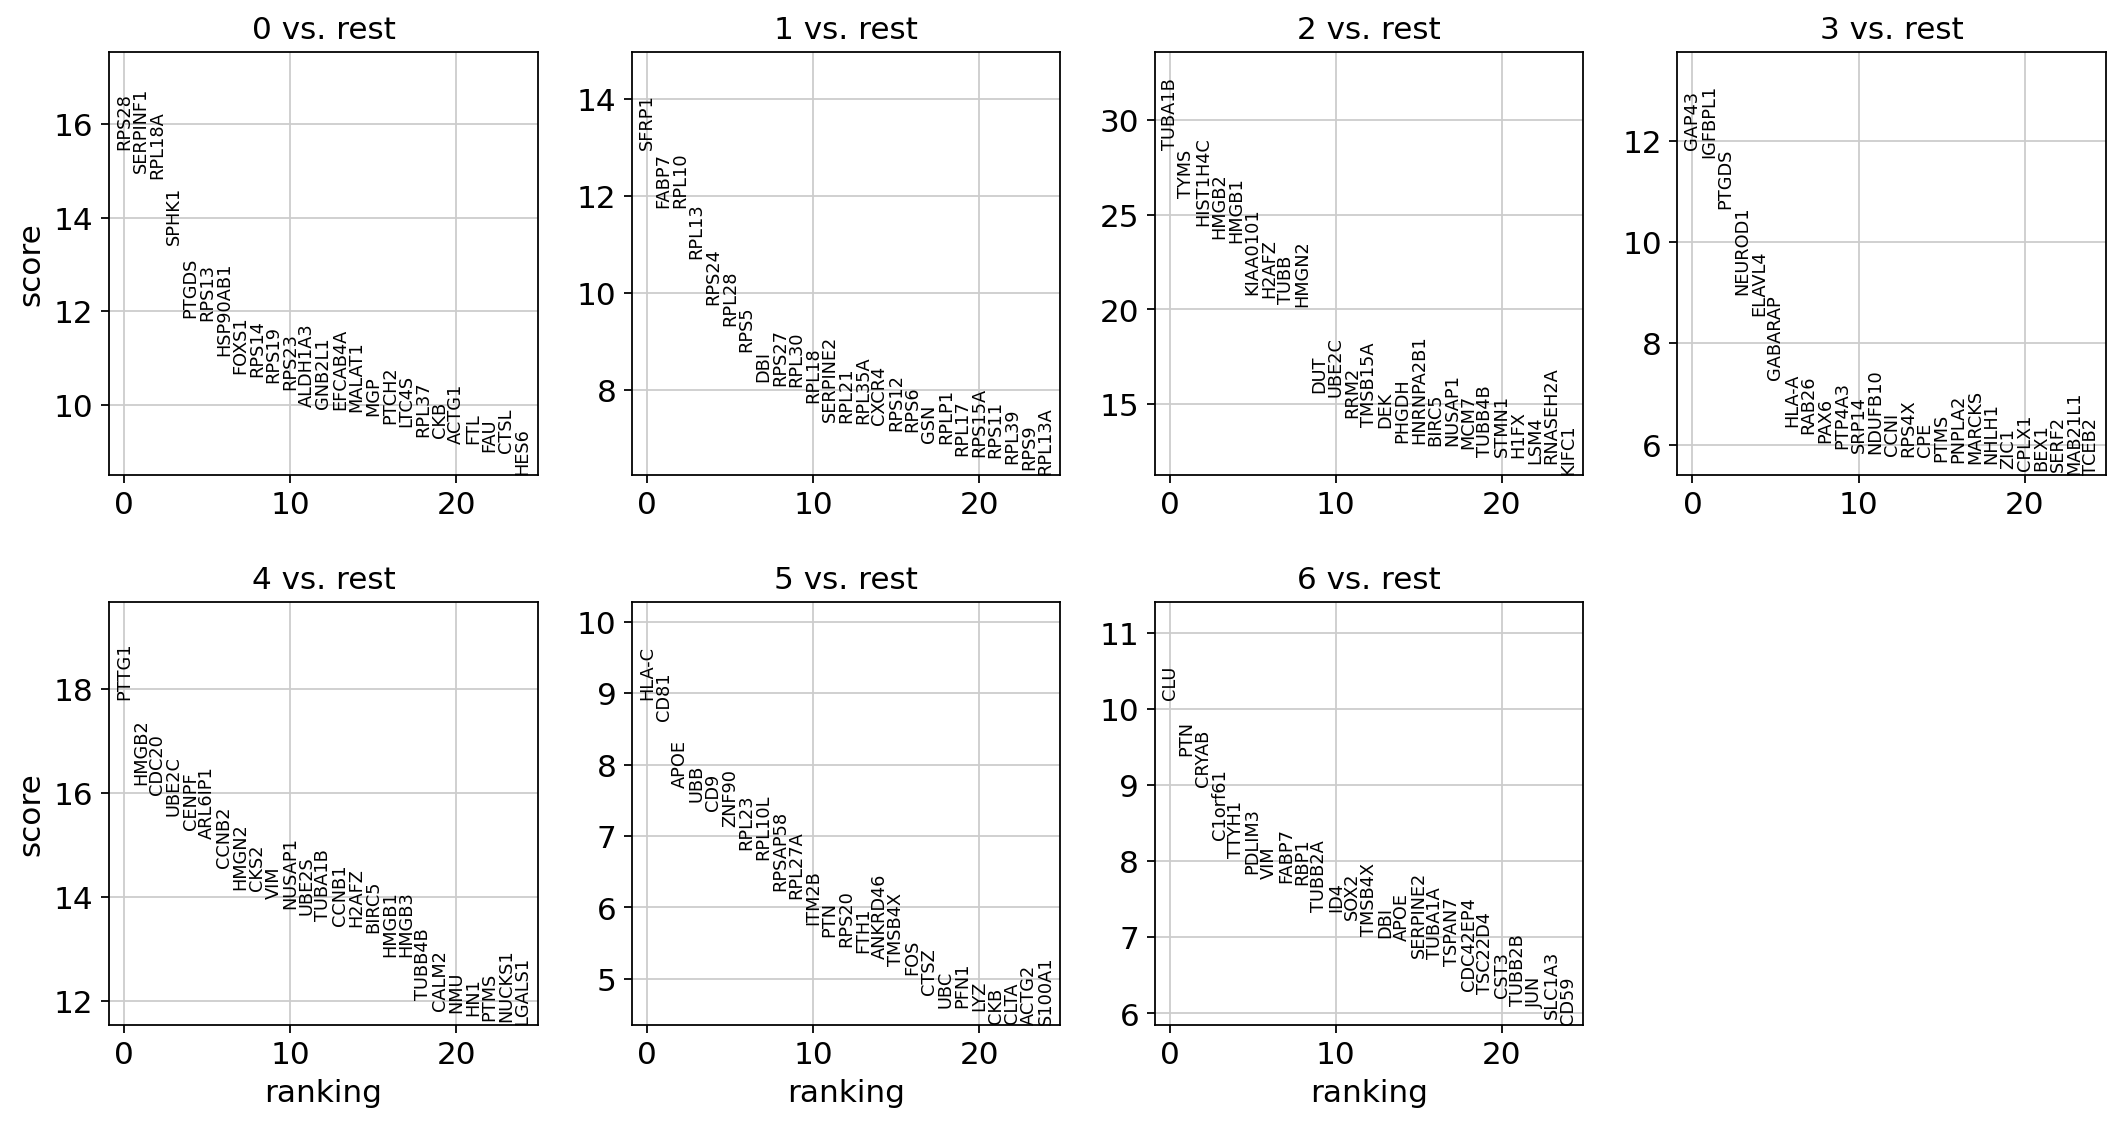

In [81]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save = "_STP-PDX_leiden.pdf")

In [82]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6
0,RPS28,SFRP1,TUBA1B,GAP43,PTTG1,HLA-C,CLU
1,SERPINF1,FABP7,TYMS,IGFBPL1,HMGB2,CD81,PTN
2,RPL18A,RPL10,HIST1H4C,PTGDS,CDC20,APOE,CRYAB
3,SPHK1,RPL13,HMGB2,NEUROD1,UBE2C,UBB,C1orf61
4,PTGDS,RPS24,HMGB1,ELAVL4,CENPF,CD9,TTYH1


In [83]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', "scores", 'logfoldchanges', "pvals", 'pvals_adj']})

In [84]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/STP-PDX_DEG_wilcoxon.csv")

In [85]:
new_cluster_names = ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6']
adata.rename_categories('leiden', new_cluster_names)

old_to_new = dict(
    cluster0='malignant SHH',
    cluster1='malignant basal state',
    cluster2='malignant cycling I',
    cluster3='malignant neuronal development',
    cluster4='malignant cycling II',
    cluster5='miroglia',
    cluster6='astrocytes'
)

adata.obs['new_clusters'] = (
    adata.obs['leiden']
    .map(old_to_new)
    .astype('category')
)

/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


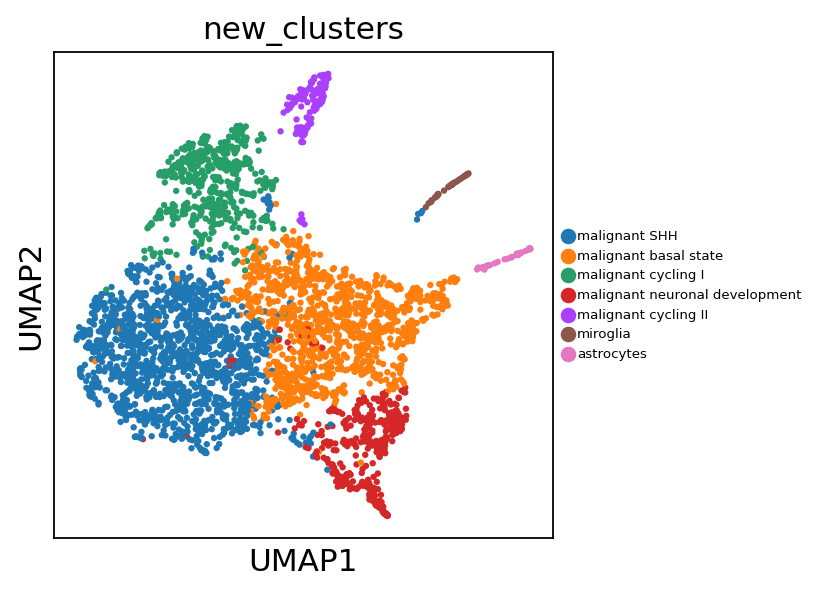

In [86]:
sc.pl.umap(adata, color=['new_clusters'], save = '_STP-PDX_Aurelie_CellType.pdf', wspace = 0.6, legend_fontsize = 6)

In [87]:
adata.write("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/STP-PDX_Aurelie_Celltype_scanpy.h5ad")

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [88]:
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/STP-PDX_metadata.csv')

In [89]:
adata.obs

,sample,technology,patient,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,louvain,leiden,new_clusters
AAACCTGCACGTTGGC-1,STP,PDX,ST,565,565,745.0,16.0,2.147651,87.0,11.677853,0,cluster0,malignant SHH
AAACCTGGTGCACTTA-1,STP,PDX,ST,943,941,2066.0,151.0,7.308809,691.0,33.446274,0,cluster1,malignant basal state
AAACCTGTCAATACCG-1,STP,PDX,ST,1036,1034,2298.0,101.0,4.395126,748.0,32.550041,0,cluster0,malignant SHH
AAACCTGTCGCGTAGC-1,STP,PDX,ST,1031,1030,2480.0,101.0,4.072580,842.0,33.951614,0,cluster0,malignant SHH
AAACGGGAGGTCATCT-1,STP,PDX,ST,974,974,2096.0,152.0,7.251909,655.0,31.250000,0,cluster0,malignant SHH
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTACCGGA-1,STP,PDX,ST,1243,1241,2713.0,69.0,2.543310,785.0,28.934759,2,cluster2,malignant cycling I
TTTGTCACACCTTGTC-1,STP,PDX,ST,968,968,1582.0,64.0,4.045512,322.0,20.353981,1,cluster0,malignant SHH
TTTGTCATCACCATAG-1,STP,PDX,ST,660,660,1399.0,78.0,5.575411,490.0,35.025017,0,cluster0,malignant SHH
TTTGTCATCAGAGACG-1,STP,PDX,ST,981,981,2060.0,117.0,5.679612,621.0,30.145630,0,cluster0,malignant SHH


## PROJECT ALIGNED SCDNA CLONES ONTO EMBEDDING

In [90]:
scDNA_clones = pd.read_csv("/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/STP-PDX/STP-PDX_scDNA_clones_filtered_cells.txt", sep = '\t', index_col=0)
scDNA_clones

,clone_id,pearson.correlation,Clone1,Clone2,Clone3,Clone4,Clone5,Clone6,Clone1_pval,Clone2_pval,Clone3_pval,Clone4_pval,Clone5_pval,Clone6_pval,num_pval_clones,min_pval,padj
Cell_barcode,,,,,,,,,,,,,,,,,
AAATGCCGTTACGACT-1,Clone6,0.068334,-0.193303,-0.118114,-0.288291,-0.191449,-0.184313,-0.068334,0.907,0.004,1.001,0.885,0.792,0.001,0,0.001,0.006
ACATGGTTCGTCGTTC-1,Clone1,0.034426,-0.034426,-0.098932,-0.368589,-0.127055,-0.157122,-0.124430,0.001,0.004,1.001,0.098,0.629,0.073,0,0.001,0.006
GGGCACTAGCCACGTC-1,Clone1,0.124031,-0.124031,-0.142088,-0.408023,-0.179869,-0.170232,-0.160355,0.002,0.004,1.001,0.239,0.117,0.046,0,0.002,0.012
ACATCAGAGACGCACA-1,Clone2,0.007476,-0.033859,0.007476,-0.304193,-0.048959,-0.160131,-0.055203,0.001,0.001,1.001,0.001,0.999,0.005,3,0.001,0.006
CGAATGTCACAAGACG-1,Clone1,0.089625,-0.089625,-0.224797,-0.396232,-0.210172,-0.271639,-0.234342,0.001,0.429,1.001,0.156,0.994,0.642,0,0.001,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATTCTACAGGGATCTG-1,Clone3,0.160082,-0.048785,0.006251,0.160082,0.087993,-0.057990,-0.002791,1.001,0.859,0.001,0.001,1.001,0.944,2,0.001,0.006
CGGTTAAGTTACGGAG-1,Clone3,0.251949,-0.087079,0.240114,0.251949,0.213787,-0.011666,0.153114,1.001,0.001,0.001,0.001,1.001,0.036,3,0.001,0.006
GCAGCCACAGCCTTGG-1,Clone3,0.063896,-0.082942,-0.034475,0.063896,0.024116,-0.074035,-0.101275,0.996,0.596,0.001,0.007,0.992,1.001,0,0.001,0.006


In [91]:
scDNA_clones = scDNA_clones.loc[scDNA_clones['padj'] <= 0.05, :]
scDNA_clones

,clone_id,pearson.correlation,Clone1,Clone2,Clone3,Clone4,Clone5,Clone6,Clone1_pval,Clone2_pval,Clone3_pval,Clone4_pval,Clone5_pval,Clone6_pval,num_pval_clones,min_pval,padj
Cell_barcode,,,,,,,,,,,,,,,,,
AAATGCCGTTACGACT-1,Clone6,0.068334,-0.193303,-0.118114,-0.288291,-0.191449,-0.184313,-0.068334,0.907,0.004,1.001,0.885,0.792,0.001,0,0.001,0.006
ACATGGTTCGTCGTTC-1,Clone1,0.034426,-0.034426,-0.098932,-0.368589,-0.127055,-0.157122,-0.124430,0.001,0.004,1.001,0.098,0.629,0.073,0,0.001,0.006
GGGCACTAGCCACGTC-1,Clone1,0.124031,-0.124031,-0.142088,-0.408023,-0.179869,-0.170232,-0.160355,0.002,0.004,1.001,0.239,0.117,0.046,0,0.002,0.012
ACATCAGAGACGCACA-1,Clone2,0.007476,-0.033859,0.007476,-0.304193,-0.048959,-0.160131,-0.055203,0.001,0.001,1.001,0.001,0.999,0.005,3,0.001,0.006
CGAATGTCACAAGACG-1,Clone1,0.089625,-0.089625,-0.224797,-0.396232,-0.210172,-0.271639,-0.234342,0.001,0.429,1.001,0.156,0.994,0.642,0,0.001,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATTCTACAGGGATCTG-1,Clone3,0.160082,-0.048785,0.006251,0.160082,0.087993,-0.057990,-0.002791,1.001,0.859,0.001,0.001,1.001,0.944,2,0.001,0.006
CGGTTAAGTTACGGAG-1,Clone3,0.251949,-0.087079,0.240114,0.251949,0.213787,-0.011666,0.153114,1.001,0.001,0.001,0.001,1.001,0.036,3,0.001,0.006
GCAGCCACAGCCTTGG-1,Clone3,0.063896,-0.082942,-0.034475,0.063896,0.024116,-0.074035,-0.101275,0.996,0.596,0.001,0.007,0.992,1.001,0,0.001,0.006


In [92]:
adata.obs['clone_id'] = scDNA_clones['clone_id']
adata.obs['padj'] = scDNA_clones['padj']

In [93]:
adata.uns['clone_id_colors'] = np.array(["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#FFFF33", "#808080"])

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'clone_id' as categorical


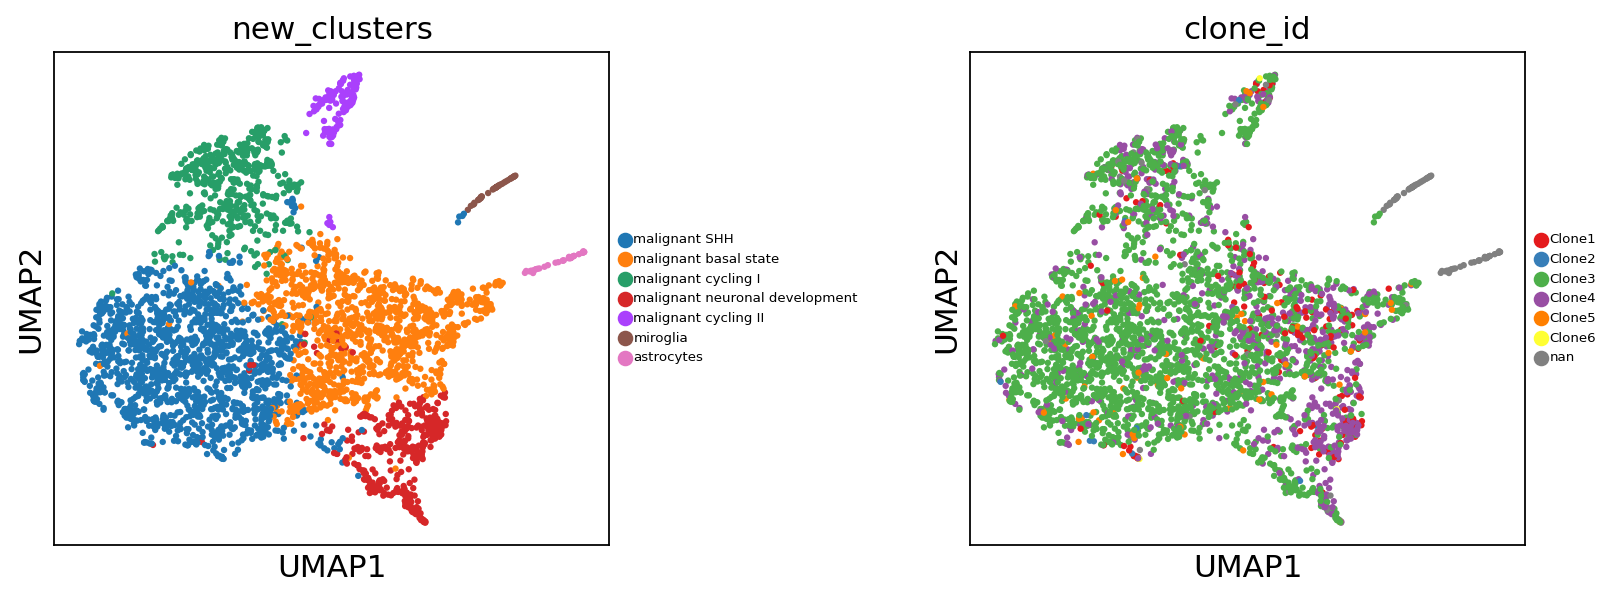

In [94]:
sc.pl.umap(adata, color=['new_clusters', 'clone_id'], save = '_STP-PDX_scDNA_clones_integrated.pdf', wspace = 0.5, legend_fontsize = 6)

In [95]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/infercnv_MB/STP-PDX_aligned_scDNA_metadata.csv')

ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


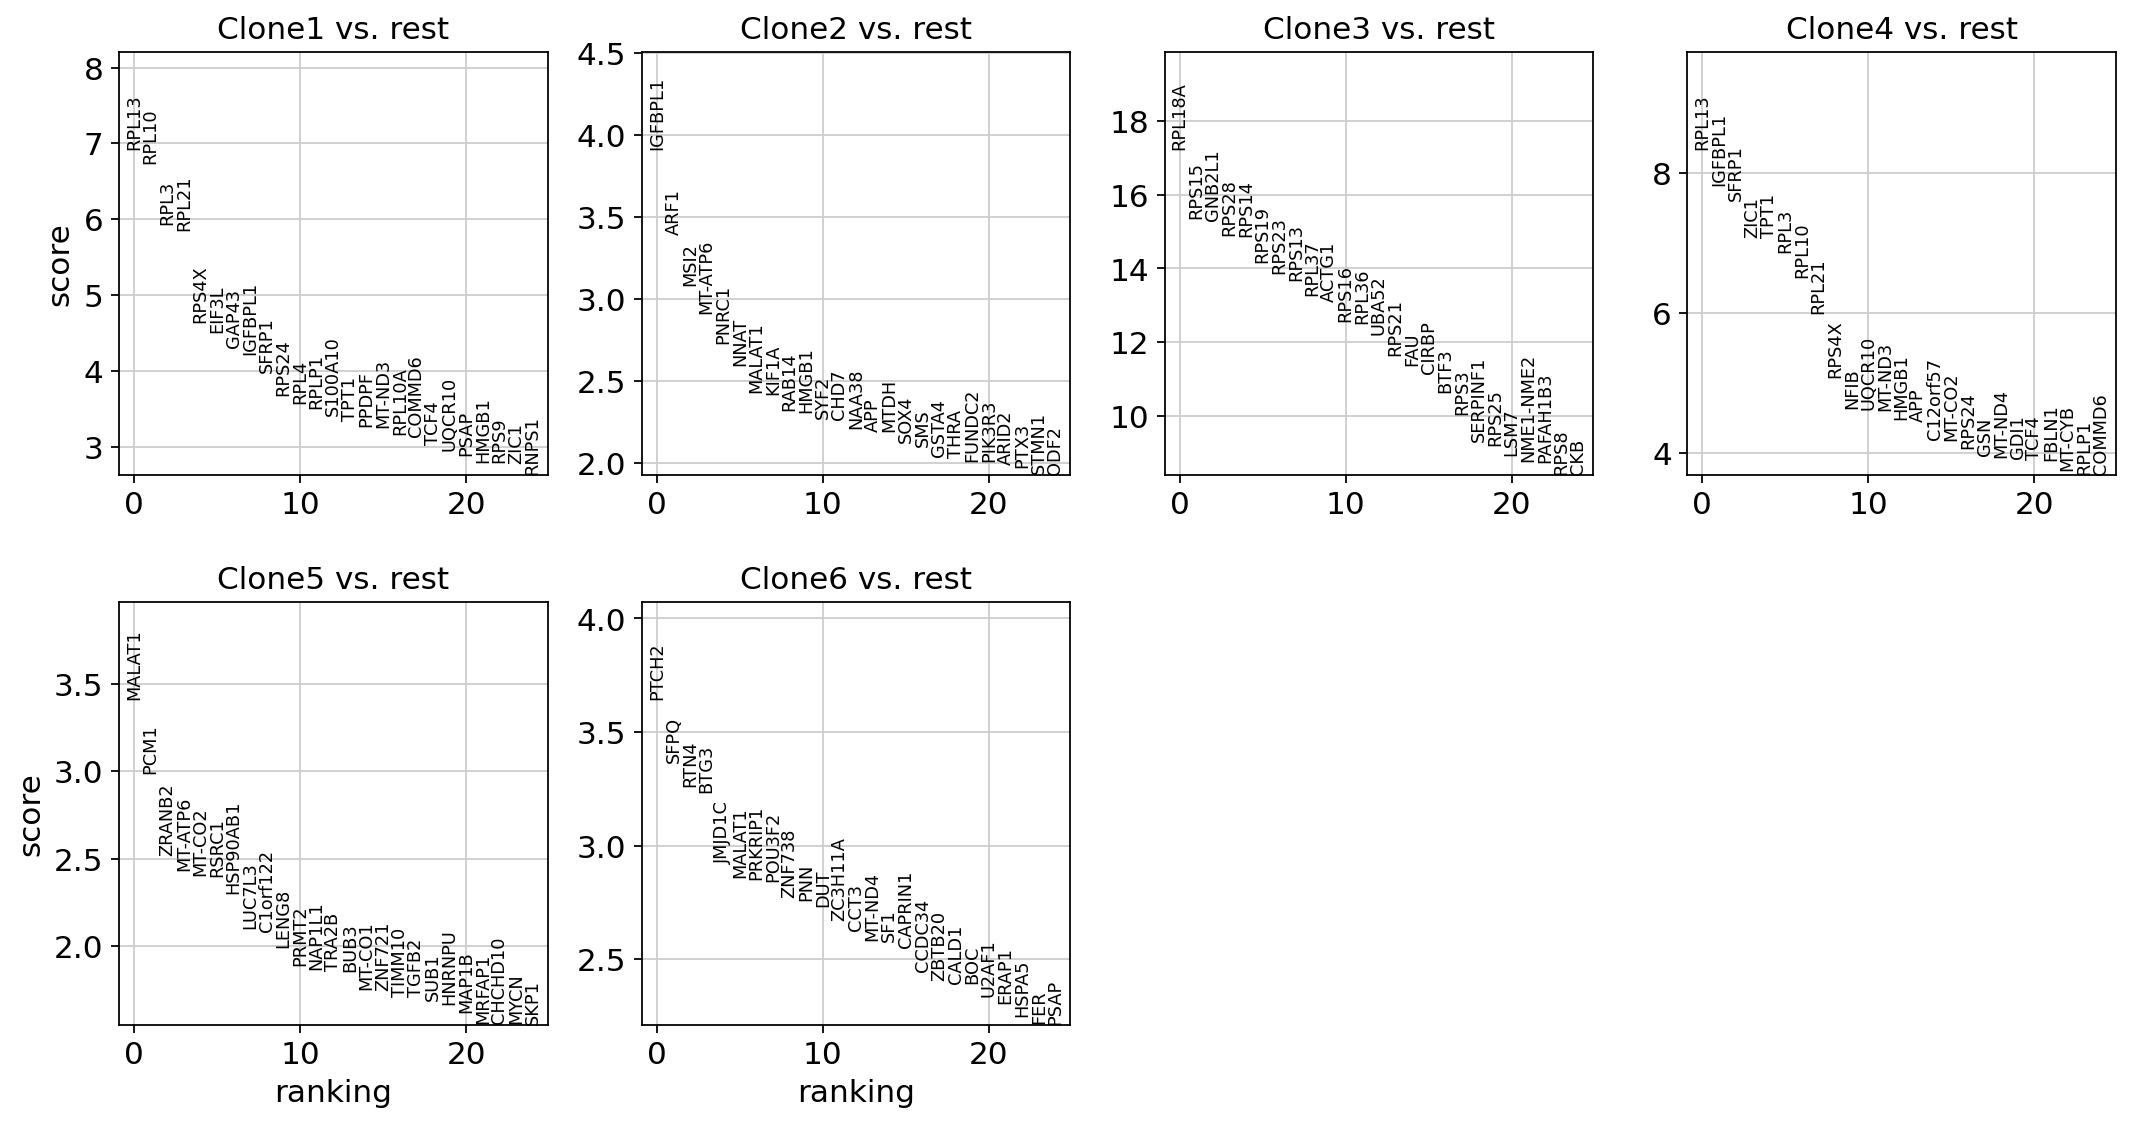

In [96]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(
            adata,
            groupby='clone_id',
            groups=["Clone1", 'Clone2', 'Clone3', 'Clone4', 'Clone5', 'Clone6'],
            reference='rest',
            use_raw=True,
            method='wilcoxon',
            n_genes=2000,
            corr_method='benjamini-hochberg'
        )
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [97]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'scores', "pvals", 'pvals_adj']})

In [98]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/STP-PDX_DEG_wilcoxon_integrated_scDNA_clones_only.csv")

In [99]:
wilcoxon_df

,Clone1_n,Clone1_l,Clone1_s,Clone1_p,Clone2_n,Clone2_l,Clone2_s,Clone2_p,Clone3_n,Clone3_l,...,Clone4_s,Clone4_p,Clone5_n,Clone5_l,Clone5_s,Clone5_p,Clone6_n,Clone6_l,Clone6_s,Clone6_p
0,RPL13,0.359963,6.921135,5.652826e-08,IGFBPL1,2.714670,3.911454,0.243246,RPL18A,0.432559,...,8.342896,8.354264e-14,MALAT1,0.468846,3.410445,1.0,PTCH2,3.480511,3.644685,0.652664
1,RPL10,0.293085,6.741711,8.418321e-08,ARF1,2.139908,3.391614,0.615552,RPS15,0.422808,...,7.824955,4.551935e-12,PCM1,1.629038,2.987828,1.0,SFPQ,3.445747,3.368546,0.702906
2,RPL3,0.616732,5.937377,7.787840e-06,MSI2,3.177100,3.079173,0.999392,GNB2L1,0.532549,...,7.608045,2.362977e-11,ZRANB2,0.968189,2.519733,1.0,RTN4,3.536824,3.258774,0.715012
3,RPL21,0.709075,5.855896,1.093527e-05,MT-ATP6,0.939195,2.913688,0.999392,RPS28,0.351179,...,7.081510,1.106720e-09,MT-ATP6,0.284594,2.431429,1.0,BTG3,3.785785,3.233574,0.715012
4,RPS4X,0.196863,4.644199,2.754064e-03,PNRC1,1.570003,2.730440,0.999392,RPS14,0.477914,...,7.080100,1.106720e-09,MT-CO2,0.213399,2.406998,1.0,JMJD1C,4.683527,2.922625,0.999210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,DSCAM,1.462967,0.219450,1.000000e+00,COQ10B,1.899745,0.258770,0.999392,SPNS2,0.719598,...,0.198931,1.000000e+00,SRPK1,0.258166,0.213678,1.0,ZNF532,1.555779,0.502730,0.999210
1996,DUSP19,0.887358,0.219292,1.000000e+00,ANKRD10,0.982612,0.258259,0.999392,SEC63,0.076185,...,0.198390,1.000000e+00,NMU,0.428969,0.213227,1.0,CDC25B,1.805231,0.502303,0.999210
1997,RAP2A,0.363214,0.219292,1.000000e+00,PRKD2,2.163868,0.257620,0.999392,SMG7,0.416264,...,0.198370,1.000000e+00,AMH,0.785996,0.213114,1.0,VPS25,1.839072,0.502303,0.999210
1998,ZNF835,0.917132,0.219014,1.000000e+00,PPFIBP1,1.538452,0.257620,0.999392,SKA2,0.175424,...,0.198351,1.000000e+00,RP4-665J23.1,0.168946,0.213114,1.0,WNK1,1.796659,0.501876,0.999210


## PROJECT CHROMOTHRIPSIS SIGNATURE ONTO THE EMBEDDING

In [12]:
f="/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/MB_shh_filtered_table_FDR.tsv"
pos_df=pd.read_table(f, sep='\t')
pos_df=pos_df.loc[pos_df['log2FoldChange'] > 0,:]
pos_df=pos_df.loc[pos_df['padj'] <= 0.05,:]
neg_df=pd.read_table(f, sep='\t')
neg_df=neg_df.loc[neg_df['log2FoldChange'] < 0,:]
neg_df=neg_df.loc[neg_df['padj'] <= 0.05,:]

In [13]:
pos_df
neg_df

,ens_fullid,ens_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
409,ENSG00000187097.12_3,ENSG00000187097,1662.242563,-0.359350,0.109875,-3.270523,1.073486e-03,0.036798,ENTPD5
410,ENSG00000250462.8_2,ENSG00000250462,1332.612360,-0.407023,0.128259,-3.173454,1.506366e-03,0.045176,LRRC37BP1
411,ENSG00000076242.14_2,ENSG00000076242,4657.937488,-0.414492,0.112141,-3.696177,2.188700e-04,0.013763,MLH1
412,ENSG00000113812.13_3,ENSG00000113812,6868.479447,-0.436607,0.127945,-3.412451,6.438160e-04,0.026346,ACTR8
413,ENSG00000100890.15_3,ENSG00000100890,808.125224,-0.443807,0.140809,-3.151842,1.622438e-03,0.047158,KIAA0391
...,...,...,...,...,...,...,...,...,...
1042,ENSG00000237869.2,ENSG00000237869,12.804303,-5.767545,1.786001,-3.229307,1.240907e-03,0.040182,RP11-459O16.1
1043,ENSG00000183072.9_2,ENSG00000183072,260.545238,-5.943601,1.123514,-5.290188,1.220000e-07,0.000112,NKX2-5
1044,ENSG00000266736.1_2,ENSG00000266736,102.835417,-6.129589,1.766502,-3.469902,5.206490e-04,0.023260,RP11-260A9.4
1045,ENSG00000253226.1_2,ENSG00000253226,23.377382,-6.273874,1.701660,-3.686913,2.269910e-04,0.014047,HAUS1P3


In [14]:
gene_list_pos=pos_df['gene_name']
intersect_gene_list_pos=adata.var_names.isin(list(gene_list_pos))
gene_list_pos=adata.var_names[intersect_gene_list_pos]

In [15]:
len(gene_list_pos)

43

In [16]:
gene_list_neg=neg_df['gene_name']
intersect_gene_list_neg=adata.var_names.isin(list(gene_list_neg))
gene_list_neg=adata.var_names[intersect_gene_list_neg]

In [17]:
len(gene_list_neg)

57

In [18]:
sc.tl.score_genes(adata, list(gene_list_pos), ctrl_size=len(gene_list_pos), gene_pool=None, n_bins=25, score_name='Upregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, list(gene_list_neg), ctrl_size=len(gene_list_neg), gene_pool=None, n_bins=25, score_name='Downregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)

computing score 'Upregulated_Chromothripsis_Score'
    finished: added
    'Upregulated_Chromothripsis_Score', score of gene set (adata.obs).
    842 total control genes are used. (0:00:00)
computing score 'Downregulated_Chromothripsis_Score'
    finished: added
    'Downregulated_Chromothripsis_Score', score of gene set (adata.obs).
    1164 total control genes are used. (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


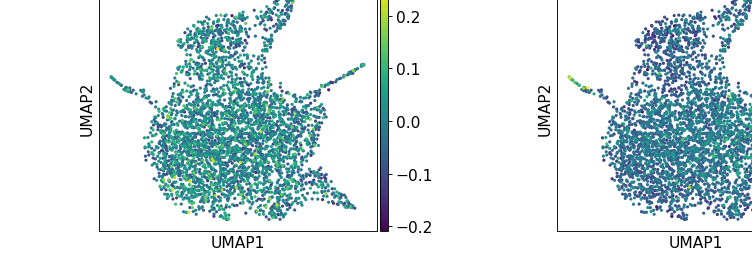

In [19]:
sc.pl.umap(adata, color=['Upregulated_Chromothripsis_Score', 'Downregulated_Chromothripsis_Score'], save = '_STP-PDX_chromothripsisScore.pdf', wspace = 0.5)

In [20]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/STP-PDX_chromothripsisScore_metadata.csv')

In [21]:
metadata

,sample,technology,patient,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,louvain,leiden,new_clusters,clone_id,min_pval,Upregulated_Chromothripsis_Score,Downregulated_Chromothripsis_Score
AAACCTGCACGTTGGC-1,STP,PDX,ST,565,565,745.0,16.0,2.147651,87.0,11.677853,0,cluster0,malignant SHH,Clone2,0.001,0.147514,-0.012893
AAACCTGGTGCACTTA-1,STP,PDX,ST,943,941,2066.0,151.0,7.308809,691.0,33.446274,0,cluster1,malignant basal state,Clone3,0.001,-0.010079,-0.019824
AAACCTGTCAATACCG-1,STP,PDX,ST,1036,1034,2298.0,101.0,4.395126,748.0,32.550041,0,cluster0,malignant SHH,Clone3,0.001,0.023627,-0.007649
AAACCTGTCGCGTAGC-1,STP,PDX,ST,1031,1030,2480.0,101.0,4.072580,842.0,33.951614,0,cluster0,malignant SHH,Clone3,0.001,0.008762,-0.003598
AAACGGGAGGTCATCT-1,STP,PDX,ST,974,974,2096.0,152.0,7.251909,655.0,31.250000,0,cluster0,malignant SHH,Clone3,0.001,0.025763,-0.041630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTACCGGA-1,STP,PDX,ST,1243,1241,2713.0,69.0,2.543310,785.0,28.934759,2,cluster2,malignant cycling I,Clone3,0.001,-0.050533,-0.047519
TTTGTCACACCTTGTC-1,STP,PDX,ST,968,968,1582.0,64.0,4.045512,322.0,20.353981,1,cluster0,malignant SHH,Clone3,0.001,0.076579,0.000936
TTTGTCATCACCATAG-1,STP,PDX,ST,660,660,1399.0,78.0,5.575411,490.0,35.025017,0,cluster0,malignant SHH,Clone3,0.001,-0.042624,0.032446
TTTGTCATCAGAGACG-1,STP,PDX,ST,981,981,2060.0,117.0,5.679612,621.0,30.145630,0,cluster0,malignant SHH,Clone4,0.001,-0.063080,-0.063558


In [16]:
data_crosstab = pd.crosstab(metadata['new_clusters'], metadata['clone_id'], margins = False)
print(data_crosstab)

clone_id                        Clone1  Clone2  Clone3  Clone4  Clone5  \
new_clusters                                                             
malignant SHH                       16       6    1213     152      40   
malignant basal state               80       1     685     300      23   
malignant cycling I                 15       2     357     123       4   
malignant neuronal development      31       3     148     171       2   
malignant cycling II                 9       2      86      31       4   
miroglia                             0       0       0       0       0   
astrocytes                           0       0       0       0       0   

clone_id                        Clone6  nan     
new_clusters                                    
malignant SHH                        3       5  
malignant basal state                0       6  
malignant cycling I                  0      10  
malignant neuronal development       1      11  
malignant cycling II                 1 

In [17]:
data_crosstab.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/STP-PDX_contingencyTable_celltypes_clones.csv')